## Proje: Balık Türlerini Sınıflandırma Modeli
Bu projede,"A Large-Scale Fish Dataset" veri seti ve yapay sinir ağı (ANN) kullanılarak balık türlerinin sınıflandırılması yapılmıştır.

## 1. Gerekli Kütüphanelerin Yüklenmesi
Projede, görüntü işleme, veri çerçevesi yönetimi ve yapay sinir ağı (TensorFlow/Keras) kullanarak sınıflandırma işlemi yapılmıştır. Bu işlemler için gerekli kütüphaneler aşağıdaki gibidir.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
import seaborn as sns

## 2. Veri Setinin Yüklenmesi ve Düzenlenmesi
Veri setinde bulunan balık türlerine ait görüntüler ve etiketleri içeren bir DataFrame oluşturulmuştur. Ayrıca, yalnızca eğitimde kullanılacak olan verilerin bulunduğu klasör seçilmiştir.

In [25]:
label = []
path = []

# Veri seti yolunun belirtilmesi
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

# gerekli olan verilerin toplanması
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            if 'GT' not in dir_name:  # GT klasörlerini atlıyoruz
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))

# Verileri bir pandas DataFrame'e dönüştürülmesi
data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label

## 3. Balık Sınıflarının Dağılımının Gösterilmesi
Veri setinde her bir balık türünden kaç tane örnek olduğunu görmek için sınıfların dağılımın grafik ile gösterilmiştir. Bu dağılım model eğitiminde dengenin sağlanması için gereklidir.



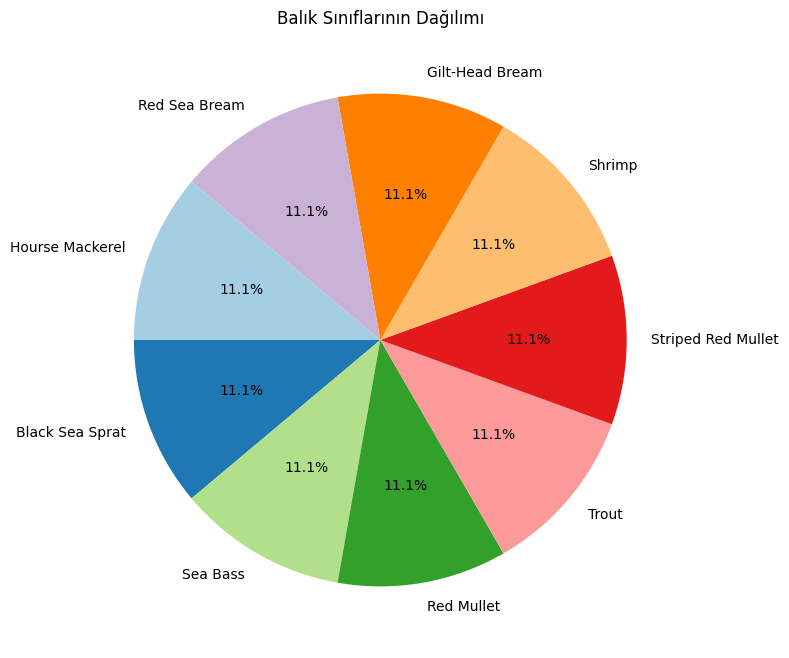

In [8]:
# Balık sınıflarının dağılımını görselleştirilmesi
label_counts = data['label'].value_counts()

# Grafiği çizdirilmesi
plt.figure(figsize=(8, 8))
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Balık Sınıflarının Dağılımı')
plt.show()



## 4. Görsellerin Yüklenmesi ve Normalizasyon
Veri çerçevesindeki her bir görüntü dosyasının yolu kullanılarak görseller yüklenir. Görüntüler 128x128 boyutuna yeniden ayarlanır ve 0-1 aralığına normalize edilir.

In [7]:
def load_images_from_dataframe(df, image_size=(128, 128)):
    images = []
    labels = []

    for i, row in df.iterrows():
        img = Image.open(row['path']).resize(image_size)
        img = np.array(img) / 255.0  # Normalizasyon 
        images.append(img)
        labels.append(row['label'])
    
    return np.array(images), np.array(labels)

X_images, y_labels = load_images_from_dataframe(data)


## 5. Etiketlerin Sayısal Değerlere Dönüştürülmesi
Etiketler (balık türleri) metin formatında olduğundan, sınıflandırma işlemi için önce sayısal değerlere dönüştürülmüş ve ardından one-hot encoding uygulanmıştır.

In [9]:
# Label encoding: Etiketleri sayısal değerlere dönüştürüyoruz
unique_labels = np.unique(y_labels)
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

y_labels_numeric = np.array([label_to_index[label] for label in y_labels])

# One-hot encoding uyguluyoruz
num_classes = len(unique_labels)
y_labels_encoded = to_categorical(y_labels_numeric, num_classes)


## 6. Verilerin Eğitim ve Test Setlerine Ayrılması
Verilerin %80'i model eğitimi ve %20'si test için ayrılmıştır. 

In [10]:
# Verilerin ayrılması
X_train, X_test, y_train, y_test = train_test_split(X_images, y_labels_encoded, test_size=0.2, random_state=42)


## 7. Modelin Oluşturulması
Yapay sinir ağı (ANN) modeli tanımlanıyor. Modelde bir input bir flatten katmanı, üç gizli dense katman ve bir çıkış katmanı bulunmaktadır. Dropout katmanları ile aşırı öğrenmeyi engellemeye çalışılmıştır.

In [22]:
model = Sequential()

# Input katmanının eklenmesi
model.add(Input(shape=(128, 128, 3)))

# Flatten katmanı ile giriş görüntülerinin düzleştirilmesi
model.add(Flatten())

# Gizli katmanların eklenmesi
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Çıkış katmanının eklenmesi
model.add(Dense(num_classes, activation='softmax'))

# Modelin derlenmesi
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

## 8. Modelin Eğitimi Ve Sonuçların Görselleştirilmesi
Modeli eğitilip, doğrulama verileri ile birlikte her epoch sonunda kayıp ve doğruluk değerlerini gözlemlenmiştir.

Epoch 1/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - accuracy: 0.1372 - loss: 2.3739 - val_accuracy: 0.2458 - val_loss: 2.0917
Epoch 2/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.2099 - loss: 2.0898 - val_accuracy: 0.3451 - val_loss: 1.9469
Epoch 3/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.2548 - loss: 1.9900 - val_accuracy: 0.3757 - val_loss: 1.8037
Epoch 4/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.2797 - loss: 1.9164 - val_accuracy: 0.4035 - val_loss: 1.7105
Epoch 5/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3131 - loss: 1.8424 - val_accuracy: 0.4243 - val_loss: 1.6590
Epoch 6/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3154 - loss: 1.8176 - val_accuracy: 0.4354 - val_loss: 1.5987
Epoch 7/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3598 - loss: 1.7557 - val_accuracy: 0.4271 - val_loss: 1.5366
Epoch 8/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3742 - loss: 1.6897 - val_accuracy: 0.4660 -

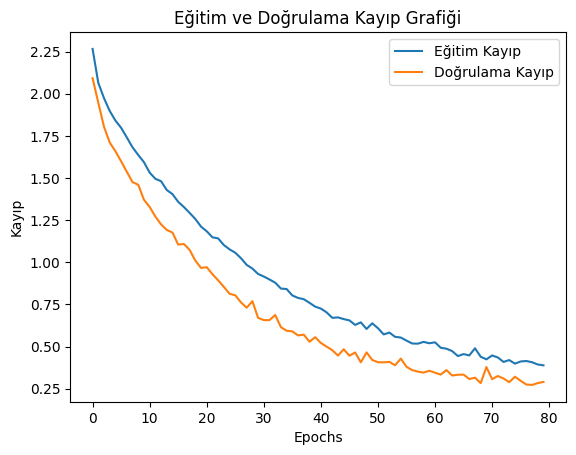

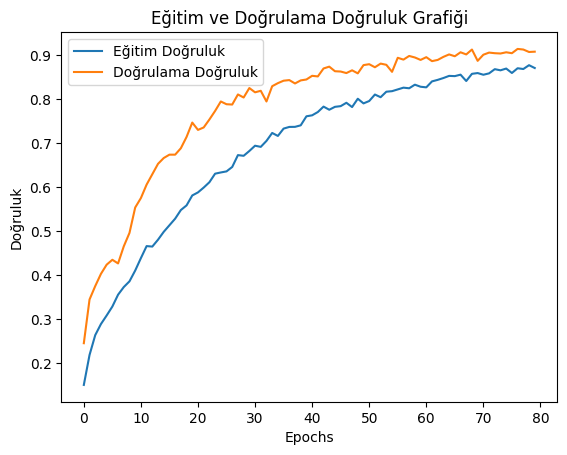

In [23]:
# Modeli eğitelmesi
history = model.fit(X_train, y_train, epochs=80, batch_size=256, validation_split=0.2)

# Eğitim ve doğrulama sonuçlarını görselleştirelmsei
import matplotlib.pyplot as plt

# Kayıp grafiği
plt.plot(history.history['loss'], label='Eğitim Kayıp')
plt.plot(history.history['val_loss'], label='Doğrulama Kayıp')
plt.title('Eğitim ve Doğrulama Kayıp Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# Doğruluk grafiği
plt.plot(history.history['accuracy'], label='Eğitim Doğruluk')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluk')
plt.title('Eğitim ve Doğrulama Doğruluk Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

## 9. Test Seti Üzerinde Değerlendirme
Eğitilen model test seti üzerinde değerlendirilmiş ve nihai doğruluk ve kayıp değerleri hesaplanmıştır.

In [24]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Kayıp: {test_loss}')
print(f'Test Doğruluk: {test_accuracy}')


Test Kayıp: 0.30208688974380493
Test Doğruluk: 0.9055555462837219


## SONUÇ
Test seti üzerindeki sonuçlara göre:
Test Kayıp: 0.302
Test Doğruluk: %90.56
Bu sonuçlar, modelin test seti üzerinde oldukça başarılı olduğunu ve yüksek doğruluk oranına sahip olduğunu göstermektedir. Eğitim ve doğrulama setleri ile karşılaştırıldığında, test setinde de oldukça iyi bir genelleme sağlanmıştır.Test Doğruluğu (%90.56), doğrulama seti üzerindeki doğrulukla (%90.83) oldukça uyumludur, bu da modelin overfitting yapmadığını ve veri setine iyi uyum sağladığını göstermiştir.